# Importing Libraries and Data

In [1]:
from data import ohlcv_adjusted_mag7_data

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import json
from datetime import datetime
import random

In [2]:
# Run before importing torch. This is for cuda memory allocation error. Doesn't fix it tho.
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from mpt import markowitz_optimization_pytorch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
# For Colab
from google.colab import drive
drive.mount('/content/drive')
sys.path.append("/content/drive/MyDrive/Diplom/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# For Colab
df = pd.read_csv("/content/drive/MyDrive/Diplom/data/close_adjusted_17.csv")

In [7]:
# For Kaggle
# df = pd.read_csv("/kaggle/input/stock-prices/data/close_adjusted_17.csv")

In [2]:
# For Local
df = ohlcv_adjusted_mag7_data.get_close()

# Fixing seed

In [40]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Cleaning dataframe

In [8]:
# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Set 'date' as index
df.set_index("date", inplace=True)

#Getting rid of missing values
df = df.dropna(axis=1)

In [9]:
df.shape

(4378, 378)

In [10]:
# Train Data: 2006-2017
train_prices = df.loc[:'2017']

# Validation Data: 2018
val_prices = df.loc['2018']

# Test Data: 2019 onward
test_prices = df.loc['2019':]

In [11]:
train_returns = ((train_prices - train_prices.shift(1)) / train_prices.shift(1)).iloc[1:]
val_returns = ((val_prices - val_prices.shift(1)) / val_prices.shift(1)).iloc[1:]
test_returns = ((test_prices - test_prices.shift(1)) / test_prices.shift(1)).iloc[1:]

In [12]:
train_prices = train_prices.iloc[1:]
val_prices = val_prices.iloc[1:]
test_prices = test_prices.iloc[1:]

In [13]:
train_prices.shape, val_prices.shape, test_prices.shape

((3018, 378), (250, 378), (1107, 378))

In [14]:
train_returns.shape, val_returns.shape, test_returns.shape

((3018, 378), (250, 378), (1107, 378))

In [15]:
train_returns.describe()

,CSCO.close,TROW.close,ISRG.close,PRGO.close,TPR.close,DVN.close,MRO.close,BA.close,GILD.close,EQIX.close,...,M.close,CRM.close,PGR.close,WAT.close,BWA.close,LRCX.close,NWL.close,UAA.close,BLK.close,PPL.close
count,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,...,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000
mean,0.000485,0.000724,0.001055,0.000807,0.000468,0.000205,0.000399,0.000720,0.000747,0.001113,...,0.000360,0.001160,0.000498,0.000702,0.000720,0.000830,0.000417,0.000894,0.000862,0.000306
std,0.018361,0.023482,0.025874,0.020220,0.024315,0.025126,0.027014,0.017455,0.019056,0.023538,...,0.027173,0.026764,0.017207,0.017925,0.024140,0.023793,0.021565,0.030767,0.022711,0.014213
min,-0.162109,-0.179387,-0.172167,-0.211412,-0.185706,-0.166888,-0.195645,-0.089290,-0.143383,-0.330669,...,-0.175247,-0.184533,-0.130179,-0.200055,-0.136625,-0.146129,-0.273147,-0.257429,-0.155242,-0.131840
25%,-0.007253,-0.008911,-0.009461,-0.008821,-0.010933,-0.012409,-0.012472,-0.008048,-0.009126,-0.009878,...,-0.011685,-0.011650,-0.007035,-0.007042,-0.010358,-0.011577,-0.008430,-0.013939,-0.008698,-0.006395
50%,0.000454,0.000373,0.000420,0.000972,0.000343,0.000000,0.000566,0.001012,0.000693,0.000855,...,0.000528,0.000206,0.000434,0.000725,0.000470,0.000787,0.000330,0.000879,0.000306,0.000799
75%,0.008605,0.009733,0.010863,0.010798,0.011278,0.013070,0.013846,0.009534,0.010473,0.010944,...,0.012243,0.013232,0.007974,0.008612,0.011899,0.013214,0.009296,0.015506,0.010610,0.007459
max,0.159501,0.181666,0.323227,0.183899,0.204482,0.214667,0.233562,0.154628,0.138239,0.171050,...,0.181808,0.191308,0.239742,0.162599,0.228278,0.151911,0.205310,0.263383,0.195609,0.148006


# Normalizing train and test

In [16]:
# Normalizing train and validation

# scaler_prices = MinMaxScaler(feature_range=(0, 1))
# scaler_returns = MinMaxScaler(feature_range=(-1, 1))

# scaler_prices = StandardScaler()
scaler_returns = StandardScaler()

In [17]:
# scaler_prices.fit(train_prices)
scaler_returns.fit(train_returns)

StandardScaler()

In [18]:
train_returns = scaler_returns.transform(train_returns)
train_prices = np.array(train_prices)
# train_prices = scaler_prices.transform(train_prices)

val_returns = scaler_returns.transform(val_returns)
val_prices = np.array(val_prices)
# val_prices = scaler_prices.transform(val_prices)

# test_returns = scaler_returns.transform(test_returns)
# test_prices = scaler_prices.transform(test_prices)

In [19]:
pd.DataFrame(train_prices).describe()

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
count,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,...,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000
mean,17.853152,44.273062,45.280113,71.674671,31.069453,48.053716,20.301708,85.801565,35.661436,143.737658,...,23.608171,39.738244,17.887139,91.048791,29.138210,52.553631,19.029002,16.262475,187.725771,18.672319
std,4.687797,14.462846,25.220555,44.675041,9.099248,12.659109,6.501358,47.756548,24.825034,105.022781,...,10.604613,27.216731,7.946666,39.108638,13.478912,32.307153,9.520372,13.941268,88.150481,4.738354
min,9.524200,13.515900,9.481100,12.123100,8.119500,15.233200,6.118600,22.244300,10.178600,27.535100,...,3.554700,5.462500,6.233600,30.750000,6.574900,13.072600,2.966500,1.592300,62.190300,11.450900
25%,14.233025,32.213725,28.947275,28.312750,24.681225,41.457475,14.858425,55.160225,15.458200,66.120775,...,15.609050,13.813125,12.541800,60.300000,16.688425,33.867900,11.773850,4.845500,117.151600,14.638150
50%,17.055500,42.536100,41.959500,73.212050,30.875000,47.804900,20.004900,63.708950,19.410400,87.718300,...,22.758900,34.678750,14.786900,82.435000,29.823050,41.204900,16.363900,10.455450,146.347100,17.619050
75%,21.015450,57.452525,57.410875,103.519625,37.776125,53.985700,25.459725,115.092300,58.686225,182.612775,...,28.915550,61.252500,21.164300,115.485000,37.793100,63.355700,25.275175,23.917475,261.303025,21.821625
max,32.789000,87.639400,134.566800,178.991600,56.756500,92.032600,36.284600,283.896600,92.906800,443.745300,...,51.642900,108.800000,47.746100,200.270000,58.918100,199.743600,41.737000,53.775500,449.965500,29.977300


# Dataloader construction

## Dataset class

In [70]:
class StockDataset(Dataset):
    def __init__(self, returns_df, prices_df, window_size=100, sharpe_window=10):
        """
        returns_df: pandas DataFrame (days, 505) - daily returns
        prices_df: pandas DataFrame (days, 505) - daily prices
        window_size: int T (sequence length for LSTM)
        sharpe_window: int  R (periods over which to compute Sharpe)
        """
        assert returns_df.shape == prices_df.shape, "DataFrames must be same shape"
        self.returns = torch.tensor(returns_df, dtype=torch.float32)  # (days, S)
        self.prices = torch.tensor(prices_df, dtype=torch.float32)    # (days, S)

        # print(self.returns.shape)
        # print(self.prices.shape)

        self.T = window_size
        self.R = sharpe_window
        self.S = returns_df.shape[1]
        self.F = 2  # returns + prices
        self.max_start = len(returns_df) - self.R - self.T + 1

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx):
        """
        Returns:
            x: (R, T, S, 2) - [returns, prices]
            y: (R, S) - next-day returns
        """
        x = []
        y = []
        for r in range(self.R):
            start = idx + r
            end = start + self.T

            ret_window = self.returns[start:end]  # (T, S)
            pri_window = self.prices[start:end]   # (T, S)

            window = torch.stack([ret_window, pri_window], dim=-1)  # (T, S, 2)
            x.append(window)
            y.append(self.returns[start + self.T])  # Next-day returns

        x = torch.stack(x)  # (R, T, S, 2)
        y = torch.stack(y)  # (R, S)
        return x, y

## Hyperparameters

In [71]:
B = 8 # batch size
R = 25 # sharpe window
T = 32 # window size
S = df.shape[1] # stock count
feature_count = 8 # feature count after first dense layer
H = 32 # hidden size
num_epochs = 10 # number of epochs

# For saving model and plots
model_name = "single_layer_lstm_on_adjusted_17"
run_id = datetime.now().strftime('%Y%m%d-%H%M')
os.makedirs(run_id, exist_ok=True)

## Train and validation dataloaders

In [72]:
train_dataset = StockDataset(train_returns, train_prices, window_size=T, sharpe_window=R)
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in train_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break
print("Length of train dataloader:", len(train_dataloader))

torch.Size([8, 25, 32, 378, 2])
torch.Size([8, 25, 378])
Length of train dataloader: 371


In [73]:
val_dataset = StockDataset(val_returns, val_prices, window_size=T, sharpe_window=R)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in val_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break

print("Length of validation dataloader:", len(val_dataloader))

torch.Size([8, 25, 32, 378, 2])
torch.Size([8, 25, 378])
Length of validation dataloader: 25


In [74]:
# test_dataset = StockDataset(test_returns, test_prices[1:], window_size=T, sharpe_window=R)
# test_dataloader = DataLoader(test_dataset, batch_size=B, shuffle=True)

# for batch_data, batch_returns in test_dataloader:
#     print(batch_data.shape)
#     print(batch_returns.shape)
#     break

# print("Length of test dataloader:", len(test_dataloader))

# Model construction

## Sharpe Loss

In [86]:
def sharpe_ratio_loss(weights, returns, epsilon=1e-6):
    """
    weights: (B, R, S)
    returns: (B, R, S)
    """
    portfolio_returns = (weights * returns).sum(dim=2)  # (B, R)
    mean = portfolio_returns.mean(dim=1)
    std = portfolio_returns.std(dim=1) + epsilon
    sharpe = mean / std
    return -sharpe.mean()  # negative Sharpe to minimize

## LSTM

In [75]:
class SharpeLSTMModel(nn.Module):
    def __init__(self, num_classes=1, input_size=2, hidden_size=64, num_layers=1, feature_size=32):
        super(SharpeLSTMModel, self).__init__()

        self.num_classes = num_classes
        self.input_size = input_size  # 2 features (returns and prices)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.feature_size = feature_size

        # Feature projection layer (2 -> feature_size)
        self.feature_projection = nn.Linear(input_size, feature_size)

        # ReLU activation after projection layer
        self.relu = nn.ReLU()

        # LSTM layer
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected output layer (hidden_size -> 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B, R, T, S, _ = x.shape

        # Project features (Returns, Prices) into higher dimensionality (B, R, T, S, F)
        x = self.feature_projection(x)  # (B, R, T, S, F)

        # Apply ReLU activation
        x = self.relu(x)  # (B, R, T, S, F)

        # Reshape to (B*R*S, T, F) for LSTM
        x = x.permute(0, 1, 3, 2, 4).reshape(B * R * S, T, self.feature_size)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # (B*R*S, T, H)

        # Take output of last time step
        final_out = lstm_out[:, -1, :]  # (B*R*S, H)

        # Fully connected layer
        dense_out = self.fc(final_out)  # (B*R*S, 1)

        # Reshape back to (B, R, S)
        dense_out = dense_out.view(B, R, S)  # (B, R, S)

        # Apply softmax to get weights
        weights = F.softmax(dense_out, dim=2)  # (B, R, S)

        return weights

In [76]:
model = SharpeLSTMModel(num_classes=1, input_size=2, hidden_size=H, num_layers=1, feature_size=feature_count).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.99, weight_decay=1e-5)

## FC

In [87]:
class SharpeFCModel(nn.Module):
    def __init__(self, input_size=2, feature_size=32, hidden_size=64):
        super(SharpeFCModel, self).__init__()

        self.input_size = input_size  # 2 features: returns, prices
        self.feature_size = feature_size
        self.hidden_size = hidden_size

        # Project (returns, prices) → feature space
        self.feature_projection = nn.Linear(input_size, feature_size)
        self.relu = nn.ReLU()

        # After projection, we'll pool over time dimension
        # Then process with FC layers

        # FC block: (R * S * F) → hidden → 1 score per stock
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B, R, T, S, _ = x.shape  # (B, R, T, S, 2)

        # Project features
        x = self.feature_projection(x)  # (B, R, T, S, F)
        x = self.relu(x)

        # Aggregate over time: mean pooling
        x = x.mean(dim=2)  # (B, R, S, F)

        # Flatten and feed into FC
        x = self.fc1(x)         # (B, R, S, hidden)
        x = self.relu(x)
        x = self.fc2(x)         # (B, R, S, 1)
        x = x.squeeze(-1)       # (B, R, S)

        # Apply softmax to get portfolio weights
        weights = F.softmax(x, dim=2)  # (B, R, S)

        return weights

In [88]:
model_fc = SharpeLSTMModel(num_classes=1, input_size=2, hidden_size=H, num_layers=1, feature_size=feature_count).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer_fc = torch.optim.SGD(model_fc.parameters(), lr=1e-4, momentum=0.99, weight_decay=1e-5)

# Training

## LSTM

In [77]:
# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    for batch_data, batch_returns in train_dataloader:
        batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        weights = model(batch_data)

        # Compute training loss (Negative Sharpe ratio)
        train_loss = sharpe_ratio_loss(weights, batch_returns)
        total_train_loss += train_loss.item()

        # Backward pass
        train_loss.backward()

        # Update parameters
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)  # Average training loss for the epoch
    train_losses.append(avg_train_loss) # To plot after

    # Validation phase (after each epoch)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient calculation needed for validation
        total_val_loss = 0.0
        for batch_data, batch_returns in val_dataloader:
            batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

            # Forward pass (no gradients needed)
            weights = model(batch_data)

            # Compute validation loss (Negative Sharpe ratio)
            val_loss = sharpe_ratio_loss(weights, batch_returns)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)  # Average validation loss for the epoch
        val_losses.append(avg_val_loss)

    # Print training and validation loss for the current epoch
    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.6f}, Validation Loss = {avg_val_loss:.6f}")

Epoch 1: Training Loss = -0.026228, Validation Loss = 0.052875
Epoch 2: Training Loss = -0.027792, Validation Loss = 0.050839
Epoch 3: Training Loss = -0.028943, Validation Loss = 0.050800
Epoch 4: Training Loss = -0.029413, Validation Loss = 0.055061
Epoch 5: Training Loss = -0.031252, Validation Loss = 0.052477
Epoch 6: Training Loss = -0.032364, Validation Loss = 0.045742
Epoch 7: Training Loss = -0.033093, Validation Loss = 0.049421
Epoch 8: Training Loss = -0.034585, Validation Loss = 0.046820
Epoch 9: Training Loss = -0.036060, Validation Loss = 0.043846
Epoch 10: Training Loss = -0.036038, Validation Loss = 0.046105


## FC (empty)

In [ ]:
pass

## Train and validation losses plot

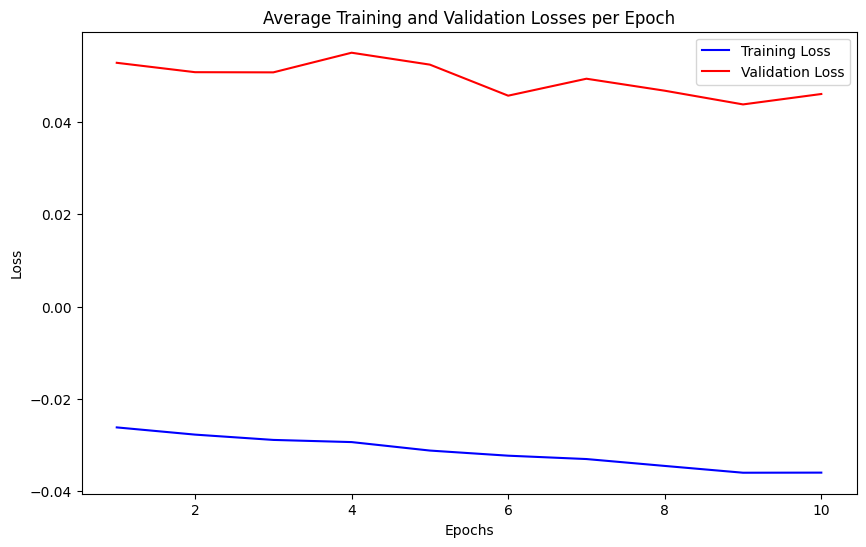

In [78]:
# Plotting train losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Losses per Epoch")
plt.legend()

# Saving plot
# plt.savefig(f"{model_name}-{run_id}/train_val_loss")

plt.show()

## Pure Markowitz

In [ ]:
# Portfolio value tracking
portfolio_value_markowitz = [1]  # Start with 1

markowitz_returns = []

# Rolling window Markowitz portfolio simulation
window_size = T  # Use past T days of returns

for t in range(window_size, len(test_returns)):

    print(t, end=', ')
    # Get Markowitz optimal weights from our weight array
    optimal_weights = markowitz_optimization_pytorch(test_returns.iloc[t-window_size:t], target_return=test_returns.mean().mean(), learning_rate=1e-3, max_iter=1000)
    # Convert to NumPy array
    optimal_weights = optimal_weights.cpu().detach().numpy()

    # Compute portfolio return on day 101
    next_day_return = np.dot(optimal_weights, np.array(test_returns.iloc[t]))

    # print(f"Weights: {optimal_weights}")
    # print(f"Day {t} return: {next_day_return}")

    # Update portfolio value
    portfolio_value_markowitz.append(portfolio_value_markowitz[-1] * (1 + next_day_return))

    markowitz_returns.append(next_day_return)

# Convert to numpy array for easier plotting
portfolio_value_markowitz = np.array([x.get() if hasattr(x, 'get') else x for x in portfolio_value_markowitz])

## Saving Model


In [ ]:
# Saving model weights
torch.save(model.state_dict(), f"{model_name}-{run_id}/weights.pth")

In [ ]:
# Saving model metadata
metadata = {
    "model": model_name,
    "B": B,
    "R": R,
    "T": T,
    "S": S,
    "feature_count": feature_count,
    "H": H,
    "num_epochs": num_epochs,
    "optimizer": "SGD",
    "loss_function": "SharpeRatioLoss",
    "notes": "FC-ReLU-LSTM-FC-Softmax. Predicting weights not returns yet."
}


with open(f"{model_name}-{run_id}/info.json", 'w') as f:
    json.dump(metadata, f, indent=4)

# Testing

In [79]:
cumulative_returns_test = [1]
cumulative_returns_equal = [1] # equal

test_predictions = []
benchmark_returns = []

testing_data = torch.stack([torch.tensor(test_prices.values, dtype=torch.float32),
                            torch.tensor(test_returns.values, dtype=torch.float32)], axis=2).to(device) # (days, S, 2)
testing_returns = torch.tensor(test_returns.values, dtype=torch.float32).to(device)

print(f"testing_data: {testing_data.shape}, testing_returns: {testing_returns.shape}")
model.eval()
with torch.no_grad():
    for t in range(T, testing_data.shape[0]):
        weights = model(testing_data[t - T:t].reshape(1, 1, T, S, 2)) # (T, S, 2) -> (S)
        weights_equal = (torch.ones(S) / S).to(device) # equal

        next_day_return = weights @ testing_returns[t]
        next_day_return_equal = weights_equal @ testing_returns[t] # equal

        cumulative_returns_test.append(cumulative_returns_test[-1] * (1 + next_day_return))
        cumulative_returns_equal.append(cumulative_returns_equal[-1] * (1 + next_day_return_equal)) # equal

        test_predictions.append(next_day_return.cpu())
        benchmark_returns.append(next_day_return_equal.cpu())

testing_data: torch.Size([1107, 378, 2]), testing_returns: torch.Size([1107, 378])


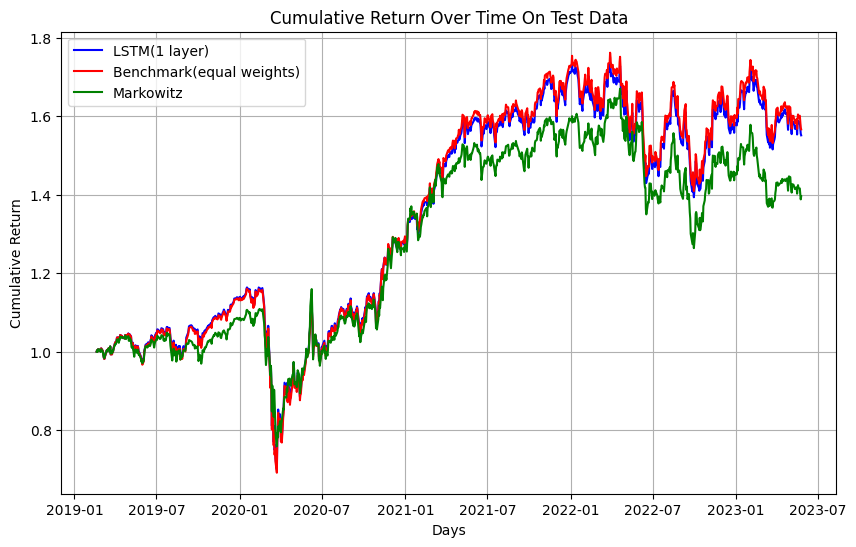

In [83]:
plt.figure(figsize=(10, 6))
plt.plot(test_prices.index.values[T - 1:], np.array([r.cpu().item() if r != 1 else r for r in cumulative_returns_test]),
         label='LSTM(1 layer)', color='blue')
plt.plot(test_prices.index.values[T - 1:], np.array([r.cpu() if r != 1 else r for r in cumulative_returns_equal]),
         label='Benchmark(equal weights)', color='red') # equal
plt.plot(test_prices.index.values[T - 1:], portfolio_value_markowitz,
         label='Markowitz', color='green') # markowitz
plt.title("Cumulative Return Over Time On Test Data")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)

# Saving plot
# plt.savefig(f"{model_name}_{run_id}/test_cum_ret")

plt.show()

## Metrics

In [81]:
test_predictions = np.array(test_predictions)
benchmark_returns = np.array(benchmark_returns)
markowitz_returns = np.array(markowitz_returns)
# test_predctions_fc = np.array(test_predictions_fc)

In [82]:
def compute_metrics(returns, cumulative_returns, risk_free_rate=0.0):
    # Expected Return
    expected_return = (cumulative_returns[-1] ** (252 / len(cumulative_returns)) - 1).item()
    # expected_return = cumulative_returns[-1].item() - 1

    # Standard Deviation
    std_dev = np.std(returns) * np.sqrt(252)

    # Downside Deviation
    downside_deviation = np.std(returns[returns < risk_free_rate]) * np.sqrt(252)

    # Sharpe Ratio
    sharpe_ratio = (expected_return - risk_free_rate) / std_dev if std_dev != 0 else np.nan

    # Sortino Ratio
    sortino_ratio = (expected_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

    # Max Drawdown
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns - peak
    max_drawdown = np.min(drawdown)

    # Assemble metrics
    metrics = {
        "Expected Return": expected_return,
        "STD": std_dev,
        "Downside Deviation": downside_deviation,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Maximum Drawdown": max_drawdown
    }

    return metrics


metrics_model = compute_metrics(test_predictions, cumulative_returns_test)
metrics_benchmark = compute_metrics(benchmark_returns, cumulative_returns_equal)
metrics_markowitz = compute_metrics(markowitz_returns, portfolio_value_markowitz)
# metrics_fc = compute_metrics(test_predctions_fc, cumulative_returns_fc)

metrics_df = pd.DataFrame({
    "LSTM": metrics_model,
    "Benchmark": metrics_benchmark,
    "Markowitz": metrics_markowitz,
    # "FC": metrics_fc
})

metrics_df

,LSTM,Benchmark,Markowitz
Expected Return,0.108309,0.110844,0.081183
STD,0.240968,0.245049,0.222282
Downside Deviation,0.195780,0.197918,0.172074
Sharpe Ratio,0.449476,0.452334,0.365224
Sortino Ratio,0.553220,0.560049,0.471789
Maximum Drawdown,-0.472174,-0.480235,-0.354129


# Junk

In [56]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached:    {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Allocated: 0.24 GB
Cached:    0.25 GB


In [63]:
torch.cuda.empty_cache()

In [ ]:
(torch.ones(S) / S)[0]

tensor(0.0020)